In [1]:
import duckdb
import matplotlib.pyplot as plt
from matplotlib.scale import LogScale
from matplotlib.ticker import FuncFormatter
import matplotlib.patheffects as PathEffects
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import copy

import seaborn as sns
import seaborn.objects as so
from seaborn import axes_style
from seaborn import plotting_context

In [2]:
r, g, b = sns.color_palette('deep')[3]
print(r * 255, g * 255, b * 255)

196.0 78.0 82.0


In [3]:
# notes:
# https://matplotlib.org/stable/users/explain/customizing.html

In [10]:
con = duckdb.connect()

con.execute("""
CREATE MACRO pretty_system(s) AS
CASE s
WHEN 'duckdb' THEN 'DuckDB'
WHEN 'hyper' THEN 'HyPer'
WHEN 'umbra' THEN 'Umbra'
ELSE s END
""")

# print(q)
con.execute(q)
systems = sorted(['duckdb', 'hyper', 'umbra'])
for system in systems:
    con.execute(f"""ATTACH IF NOT EXISTS '../results/{system}.duckdb' AS {system} (READ_ONLY TRUE);""")
con.execute(f"""CREATE VIEW IF NOT EXISTS all_results AS ({' UNION ALL '.join([f"SELECT '{system}' AS system, * FROM {system}.main.results" for system in systems])})""")
results_int_df = con.execute("""
SELECT * REPLACE (median(t) AS t)
FROM all_results
GROUP BY ALL
ORDER BY system, sf, q""").fetchdf()
results_df = con.execute("""SELECT * REPLACE(sf::VARCHAR as sf) FROM results_int_df ORDER BY system, sf::INT""").fetchdf()
results_df.head()

,system,sf,q,t
0,duckdb,32,1,2.237790
1,duckdb,32,2,3.202541
2,duckdb,32,3,5.017878
3,duckdb,32,4,6.799562
4,duckdb,32,5,7.277024


In [11]:
my_style = {
    'figure.facecolor': 'white',
    'axes.labelcolor': '.15',
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.color': '.15',
    'ytick.color': '.15',
    'axes.axisbelow': True,
    'grid.linestyle': '-',
    'text.color': '.0',
    'font.family': ['sans-serif'],
    'font.sans-serif': [
        'Arial',
        'DejaVu Sans',
        'Liberation Sans',
        'Bitstream Vera Sans',
        'sans-serif'
    ],
    'lines.solid_capstyle': 'round',
    'patch.edgecolor': 'w',
    'patch.force_edgecolor': True,
    'image.cmap': 'rocket',
    'xtick.top': False,
    'ytick.right': False,
    'axes.grid': True,
    'axes.facecolor': 'white',
    'axes.edgecolor': '.0',
    'grid.color': '.9',
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': True,
    'axes.spines.top': True,
    'xtick.bottom': False,
    'ytick.left': False
}

In [13]:
@FuncFormatter
def my_formatter(x, pos):
    if x >= 1:
        return "{:.0f}".format(x)
    return "{:.1g}".format(x)

/var/folders/xb/2cf2mnw979g7ts_gvf4nry7h0000gn/T/ipykernel_7525/3194937479.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes[0].set_xticklabels(f.axes[0].get_xticklabels(), rotation=90, fontsize=15)
/var/folders/xb/2cf2mnw979g7ts_gvf4nry7h0000gn/T/ipykernel_7525/3194937479.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes[1].set_xticklabels(f.axes[0].get_xticklabels(), rotation=90, fontsize=15)
/var/folders/xb/2cf2mnw979g7ts_gvf4nry7h0000gn/T/ipykernel_7525/3194937479.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes[2].set_xticklabels(f.axes[0].get_xticklabels(), rotation=90, fontsize=15)


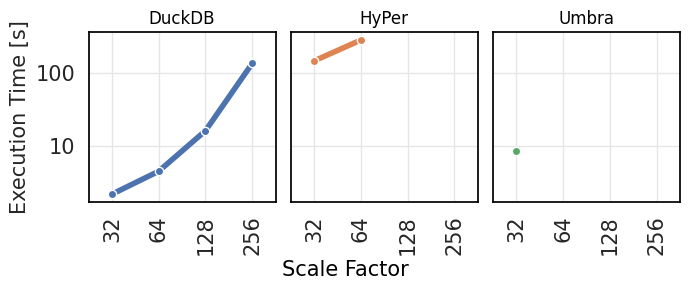

In [54]:
f = plt.figure(figsize=(7, 2.75))
modified_style = copy.copy(my_style)
modified_style['xtick.major.bottom'] = True
modified_style['axes.labelsize'] = 15
modified_style['ytick.labelsize'] = 15
# modified_style['ytick.major.left'] = False

p = (
    so.Plot(
        con.execute(f"""
            SELECT pretty_system(system) as System,
            sf AS "Scale Factor", t AS "Execution Time [s]", q as "Query"
            FROM results_df
            WHERE t > 0
            AND q = 1
        """).fetchdf(),
        x='Scale Factor', y='Execution Time [s]', color='System'
    )
    .scale(y=so.Continuous(trans='log10').label(my_formatter).tick(minor=0))
    .facet(col='System', order={"col": ["DuckDB", "HyPer", "Umbra"]})
    .add(so.Line(linewidth=4, marker='o', edgecolor='w'))
    .theme(modified_style)
    .on(f)
    .plot()
)

fsize = 20

# txt = f.axes[3].text(6, 250, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette('deep')[3], fontsize=fsize)
# txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
# txt = f.axes[3].text(7, 250, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette('deep')[3], fontsize=fsize)
# txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
# txt = f.axes[7].text(6, 250, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette('deep')[3], fontsize=fsize)
# txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
# txt = f.axes[7].text(7, 250, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette('deep')[3], fontsize=fsize)
# txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
# txt = f.axes[11].text(6, 250, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette('deep')[3], fontsize=fsize)
# txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
# txt = f.axes[11].text(7, 250, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette('deep')[3], fontsize=fsize)
# txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

# rect = patches.Rectangle((5, 0.000001), 2.5, 1000, linewidth=1, edgecolor='black', facecolor='black')
# f.axes[3].add_patch(rect)
# rect = patches.Rectangle((5, 0.000001), 2.5, 1000, linewidth=1, edgecolor='black', facecolor='black')
# f.axes[7].add_patch(rect)
# rect = patches.Rectangle((5, 0.000001), 2.5, 1000, linewidth=1, edgecolor='black', facecolor='black')
# f.axes[11].add_patch(rect)

# f.axes[0].set_title('DuckDB', fontsize=15)
# f.axes[2].set_title('HyPer', fontsize=15)
# f.axes[3].set_title('Umbra', fontsize=15)
# for i in range(4, 12):
#     f.axes[i].set_title('')

# f.axes[3].text(8, 5, "3", horizontalalignment='left', verticalalignment='center', fontsize=15)
# f.axes[7].text(8, 5, "6", horizontalalignment='left', verticalalignment='center', fontsize=15)
# f.axes[11].text(8, 5, "13", horizontalalignment='left', verticalalignment='center', fontsize=15)

for i in range(3):
    f.axes[i].grid(True, 'both')

# f.axes[0].set_ylabel('')
# f.axes[8].set_ylabel('')

f.axes[0].set_xlabel('')
f.axes[1].set_xlabel('')
f.axes[2].set_xlabel('')
f.axes[0].set_xticklabels(f.axes[0].get_xticklabels(), rotation=90, fontsize=15)
f.axes[1].set_xticklabels(f.axes[0].get_xticklabels(), rotation=90, fontsize=15)
f.axes[2].set_xticklabels(f.axes[0].get_xticklabels(), rotation=90, fontsize=15)
f.text(0.5, 0, 'Scale Factor', horizontalalignment='center', verticalalignment='center', fontsize=15)

# for i in range(3):
#     temp = f.axes[3*i]
#     f.axes[3*i] = f.axes[3*i + 1]
#     f.axes[3*i + 1] = temp

legend = f.legends.pop(0)
# f.axes[0].legend(legend.legend_handles, [t.get_text() for t in legend.texts], loc='upper left', framealpha=1, fontsize=15)
f.tight_layout()

f.savefig(f"../figures/faceted.eps", bbox_inches='tight')
# plt.close(f)